**#VapeVeritas: NLP-Powered Surveillance of E-cigarette Information on Twitter**
Alexander Xu - Great Neck South High School, Great Neck, NY

In [ ]:
#@title import libraries

!pip install snscrape
import snscrape.modules.twitter as sntwitter

from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

!pip install python-dateutil
import datetime
import dateutil.relativedelta as relativedelta
import os
import matplotlib.dates as mdates
import queue

import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer()
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import gensim
import gensim.corpora as corpora

!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from sklearn import preprocessing

import statsmodels.api as sm

!pip install pyLDAvis
import pyLDAvis.gensim_models

from IPython.display import clear_output
from google.colab import drive

clear_output()

In [ ]:
# @title Tweet extraction utility functions

# Scrapes all original tweets that were posted within a specified date range using specified keywords
# Returns tweets as a dataframe
def scrape_tweets(start_date: str, end_date: str, keywords: List[str] = KEYWORDS) -> pd.DataFrame:
    tweets_data = {
        'TweetID': [],
        'TweetContent': [],
        'TweeterUsername': [],
        'TweetDatetime': [],
    }
    
    keyword_query = ' OR '.join(keywords)
    search_query = f'({keyword_query}) since:{start_date} until:{end_date} lang:en -filter:replies'

    for tweet in sntwitter.TwitterSearchScraper(search_query).get_items():
        tweets_data['TweetID'].append(tweet.id)
        tweets_data['TweetContent'].append(tweet.content)
        tweets_data['TweeterUsername'].append(tweet.username)
        tweets_data['TweetDatetime'].append(tweet.date)

    return pd.DataFrame(tweets_data)


# Create folder to store scraped tweets
def create_month_folder(month_start_date: datetime.datetime) -> str:
    month_folder = '---------'+month_start_date.strftime('%Y-%m')
    if not os.path.exists(month_folder):
        os.mkdir(month_folder)
    return month_folder


# Loops through date range and scrapes all tweets within the date range
# Saves Tweets as CSV
def extract_and_save_tweets(start_date: datetime.datetime, end_date: datetime.datetime, output_folder: str):
    current_date = start_date
    while current_date < end_date:
        month_folder = create_month_folder(current_date)
        next_date = start_date + relativedelta.relativedelta(months=+1)
        days_difference = (next_date - current_date).days

        for _ in range(days_difference):
            day_ots = scrape_tweets(current_date.strftime(
                DATE_FORMAT), (current_date + datetime.timedelta(days=1)).strftime(DATE_FORMAT))
            day_ots.to_csv(
                f'{month_folder}/OTS-{current_date.strftime(DATE_FORMAT)}.csv')
            current_date += datetime.timedelta(days=1)

In [ ]:
# @title Tweet aggregation and preprocessing utility functions

def construct_month_folder(month_start_date: datetime.datetime) -> str:
    return month_start_date.strftime('%Y-%m')


def construct_csv_path(month_folder: str, current_date: datetime.datetime) -> str:
    return f'{month_folder}/OTS-{current_date.strftime(DATE_FORMAT)}.csv'


# Aggregate extracted tweets into a working dataframe
def aggregate_original_tweets(start_date: datetime.datetime, end_date: datetime.datetime) -> pd.DataFrame:
    current_date = start_date
    res_df = pd.DataFrame()

    for i in range(96):
        month_folder = construct_month_folder(current_date)

        next_date = start_date + relativedelta.relativedelta(months=+1)
        while current_date.month < next_date.month or current_date.year < next_date.year:
            csv_path = construct_csv_path(month_folder, current_date)

            day_df = pd.read_csv(csv_path, index_col='Unnamed: 0',
                                 lineterminator='\n', parse_dates=['TweetDatetime'])
            res_df = pd.concat([res_df, day_df], ignore_index=True)

            current_date += datetime.timedelta(days=1)

        start_date = current_date

    return res_df

# Preprocess string for sentiment classification


def preprocess_text(text: str) -> str:
    text = ' '.join(
        re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", text).split())
    text = text.lower()
    text = re.sub(r'[^A-Za-z ]+', '', text)
    text = re.sub('[,\.!?]', '', text)
    text = ' '.join([word for word in text.split(' ')
                    if word not in STOP_WORDS])
    text = ' '.join([wordnet_lemmatizer.lemmatize(word)
                    for word in text.split(' ')])

    return text.strip()


# Classify text sentiment using VADER
def classify_text_sentiment(text: str) -> float:
    return sid_obj.polarity_scores(text)['compound']

In [ ]:
# @title Diffusion tree utility functions

# Construct information cascade/diffusion tree using retweet and following list
# Approximate network using Liang et al. (2019) trick
def construct_information_cascade(retweet_list, following_list) -> Dict[str, Dict[str, str]]:
    res_dict = {}
    for name, group in retweet_list.groupby('TweetID'):
        res = {}
        root = group['TweeterUsername'].iloc[0]

        all_retweeters = list({root}.union(
            set(group['RetweeterUserUsername'].unique())))
        for user in all_retweeters:
            res[user] = root

        retweet_times = dict(
            zip(list(group['RetweeterUserUsername']), list(group['RetweetDate'])))
        for retweeter in list(group['RetweeterUserUsername'].unique()):
            for following in following_list.loc[retweeter]:
                if following in all_retweeters and (following == root or retweet_times[following] < retweet_times[retweeter]):
                    res[retweeter] = following
                    break
        res_dict[name] = res

    return res_dict


# Calculate structural virality of diffusion tree in BFS fashion
def calculate_structural_virality(tree: Dict[str, List[str]], start: str) -> int:
    structural_virality_sum = 0
    depth = 0
    visited = {}
    q = queue.Queue()

    q.put(start)
    visited[start] = depth

    while not q.empty():
        size = q.qsize()

        while size > 0:
            cur = q.get()
            structural_virality_sum += depth
            size -= 1

            if cur not in tree:
                continue

            neigh = tree[cur]
            for next_node in neigh:
                if next_node not in visited:
                    q.put(next_node)
                    visited[next_node] = depth + 1
        depth += 1

    return structural_virality_sum


# Calculate cascade metrics of diffusion tree in BFS fashion
def calculate_cascade_metrics(tree: Dict[str, List[str]], root: str) -> Tuple[int, int, int, int, int, Dict[str, int]]:
    cascade_size = 0
    cascade_scale = 0
    cascade_depth = 0
    num_nodes = 0

    depth = 0
    visited = {}
    q = queue.Queue()

    q.put(root)
    visited[root] = depth

    while not q.empty():
        size = q.qsize()

        if depth == 1:
            cascade_scale = size
        cascade_depth = max(cascade_depth, depth)

        while size > 0:
            cur = q.get()
            size -= 1
            num_nodes += 1

            if cur not in tree:
                continue

            neigh = tree[cur]
            for next_node in neigh:
                if next_node not in visited:
                    q.put(next_node)
                    visited[next_node] = depth + 1
                    cascade_size += 1
        depth += 1

    structural_virality = 0 if num_nodes == 1 else calculate_structural_virality(
        tree, root) / (num_nodes * (num_nodes - 1))

    return num_nodes, cascade_size, cascade_scale, cascade_depth, structural_virality, visited


# Filter retweets
def filter_retweets(all_retweets, all_following_list, all_tweets_df):
    following_users = pd.merge(all_following_list, all_retweets, left_on='UserUsername', right_on='RetweeterUserUsername', how='inner') \
                        .drop_duplicates('UserUsername')['RetweeterUserUsername'].tolist()
    return all_retweets[~all_retweets['RetweeterUserUsername'].isin(following_users)]


# Construct diffusion trees and extract features
def extract_graph_features(all_retweets, all_tweets_df, all_following_list):
    res_dict = construct_information_cascade(
        pd.merge(all_retweets, all_tweets_df[['TweetID', 'TweeterUsername']], on='TweetID').sort_values(
            'RetweetDate', ascending=True),
        all_following_list.groupby('UserUsername')['FollowingUsername'].unique())

    graph = {}
    for tweet_id, connections in res_dict.items():
        graph[tweet_id] = {}
        for con_from, con_to in connections.items():
            if con_to not in graph[tweet_id]:
                graph[tweet_id][con_to] = [con_from]
            else:
                graph[tweet_id][con_to].append(con_from)

            if con_from not in graph[tweet_id]:
                graph[tweet_id][con_from] = [con_to]
            else:
                graph[tweet_id][con_from].append(con_to)

    tree_features = {}
    for tweet_id, tree in tqdm(graph.items()):
        num_nodes, cascade_size, cascade_scale, cascade_depth, structural_virality, visited = calculate_cascade_metrics(
            tree, all_tweets_df.set_index('TweetID').loc[tweet_id]['TweeterUsername'])
        tree_features[tweet_id] = {
            'n': int(num_nodes),
            'm': int(cascade_size),
            'd1': int(cascade_scale),
            'h': int(cascade_depth),
            'structural_virality': float(structural_virality),
            'depth': visited
        }

    return tree_features

In [ ]:
drive.mount('/content/drive/')
%cd '---------'

wordnet_lemmatizer=WordNetLemmatizer()
sid_obj = SentimentIntensityAnalyzer()

KEYWORDS = ['juul', 'juuls', 'vape', 'vapes', 'juuling', 'vaping',
            'juuled', 'vaped', 'juuler', 'vaper', 'juulers', 'vapers']

STOP_WORDS = set(stopwords.words('english'))

START_DATE = datetime.datetime(2015, 1, 1)
END_DATE = datetime.datetime(2023, 1, 1)
DATE_FORMAT = '%Y-%m-%d'

CSV_PATH = '---------'

# Main script for original tweets

extract_and_save_tweets(START_DATE, END_DATE, '---------')

aggregated_tweets = aggregate_original_tweets(START_DATE, END_DATE)
aggregated_tweets['TweetDate'] = aggregated_tweets['TweetDatetime'].dt.strftime(DATE_FORMAT).astype("datetime64")
all_tweets_df = aggregated_tweets.sort_values('TweetDatetime', ascending=True).drop_duplicates('TweetContent', keep='first')

all_tweets_df['ProcessedContent'] = all_tweets_df['TweetContent'].apply(lambda x: preprocess_text(x))
all_tweets_df['VADER_sentiment_score'] = all_tweets_df['ProcessedContent'].apply(lambda x: classify_text_sentiment(str(x)))
all_tweets_df['VADER_sentiment_class'] = all_tweets_df['VADER_sentiment_score'].apply(lambda x: 1 if x >= 0.2 else -1 if x <= -0.2 else 0)

clear_output()

In [ ]:
# Main script for retweets

all_retweets = pd.read_csv('---------')
all_following_list = pd.read_csv('---------')

filtered_retweets = filter_retweets(
    all_retweets, all_following_list, all_tweets_df)

graph_features = extract_graph_features(
    filtered_retweets, all_tweets_df, all_following_list)

min_max_scaler = preprocessing.MinMaxScaler()
working = pd.DataFrame(graph_features).T
working = working[working['n'] > 1]
working['normalized_structural_virality'] = min_max_scaler.fit_transform(
    working[['structural_virality']])
working.to_csv('---------')

100%|██████████| 245/245 [00:00<00:00, 95183.82it/s]


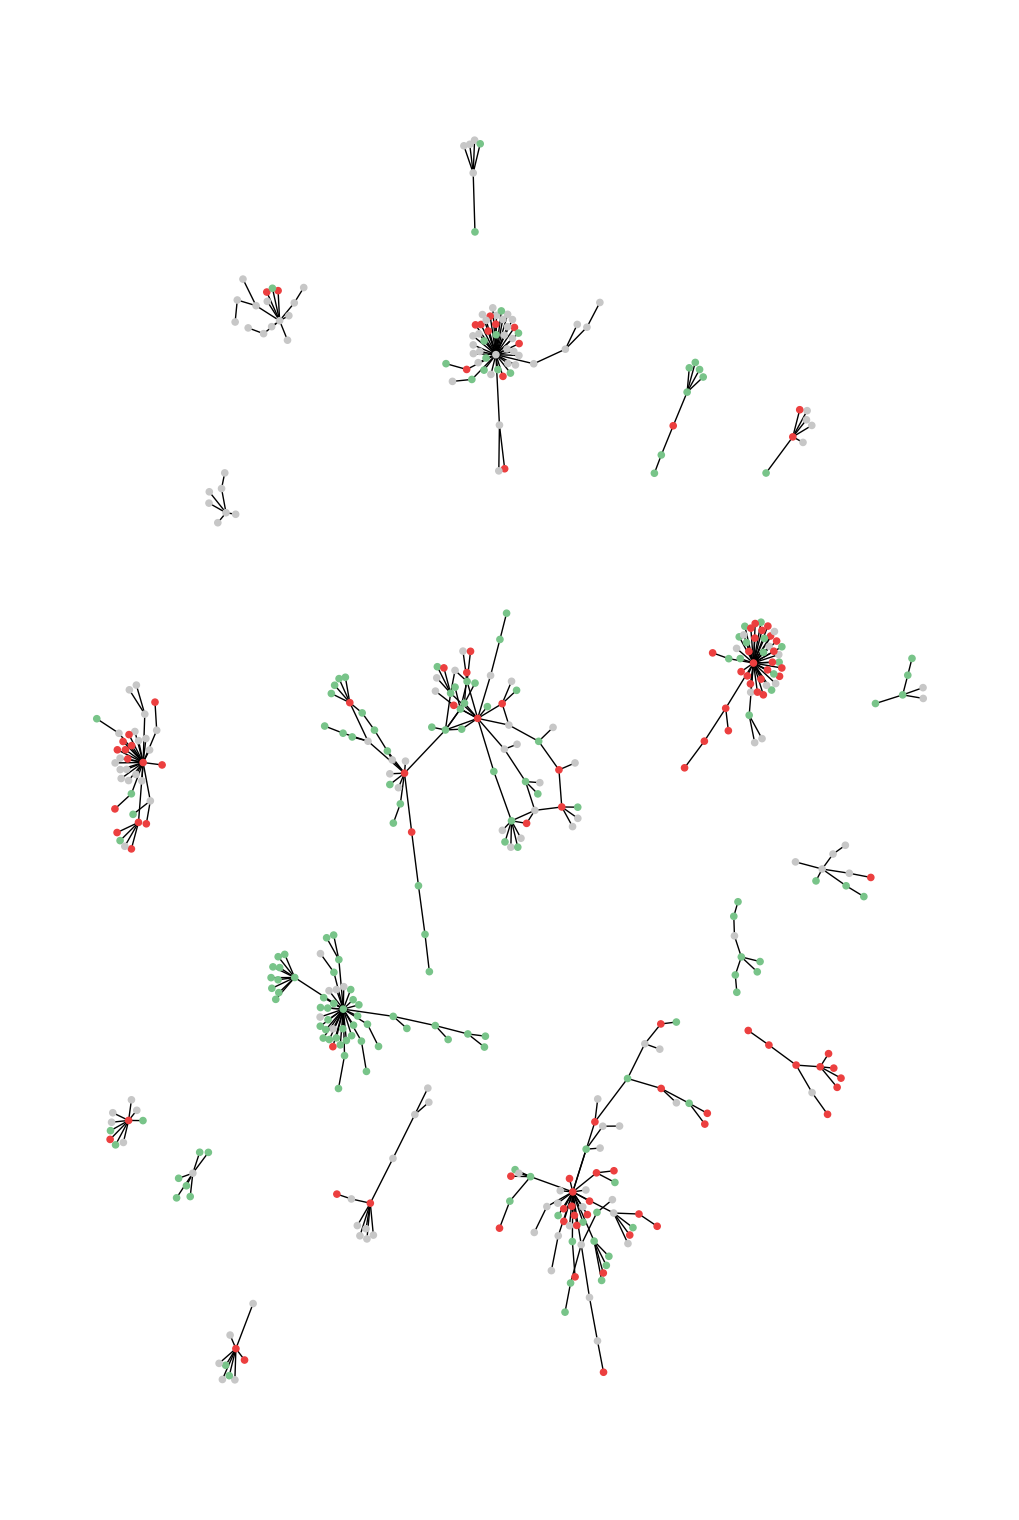

In [ ]:
# @title Visualize information cascades

id_list, from_list, to_list = [], [], []

for key, value in tqdm(graph.items()):
    for key2, value2 in value.items():
        for value3 in value2:
            id_list.append(key)
            from_list.append(key2)
            to_list.append(value3)

graph_df = pd.DataFrame({'TweetID': id_list, 'From': from_list, 'To': to_list})
graph_df = graph_df[~(graph_df['From'] == graph_df['To'])]

# Count occurrences of 'From' for each 'TweetID'
tweet_counts = graph_df.groupby('TweetID')['From'].count()

# Keep only rows where 'From' count is less than or equal to 8
filtered_tweets = tweet_counts[tweet_counts <= 8].reset_index()
filtered_tweets = filtered_tweets[filtered_tweets['From'] == True]

# Filter graph_df based on the condition
graph_df = graph_df[~graph_df['TweetID'].isin(
    filtered_tweets['TweetID'].tolist())]

# Create a graph from the DataFrame
G = nx.from_pandas_edgelist(graph_df, 'From', 'To', create_using=nx.Graph())

# Get node colors
node_colors = pd.Categorical(pd.concat([all_tweets_df[all_tweets_df['TweetID'].isin(graph.keys())][['TweeterUsername', 'VADER_sentiment_class']], all_retweets[['RetweeterUserUsername', 'VADER_sentiment_class']].rename(
    {'RetweeterUserUsername': 'TweeterUsername'}, axis=1)], ignore_index=True).drop_duplicates('TweeterUsername').set_index('TweeterUsername').reindex(G.nodes())['VADER_sentiment_class']).codes

# Visualize the graph
nx.draw(G, with_labels=False, node_color=node_colors,
        cmap=mpl.colors.LinearSegmentedColormap.from_list('', ['#ec3f3f', '#c7c7c7', '#78c489']), node_size=20, arrows=True)
plt.rcParams["figure.figsize"] = (15, 10)
plt.show()

<Axes: xlabel='normalized_structural_virality', ylabel='Density'>

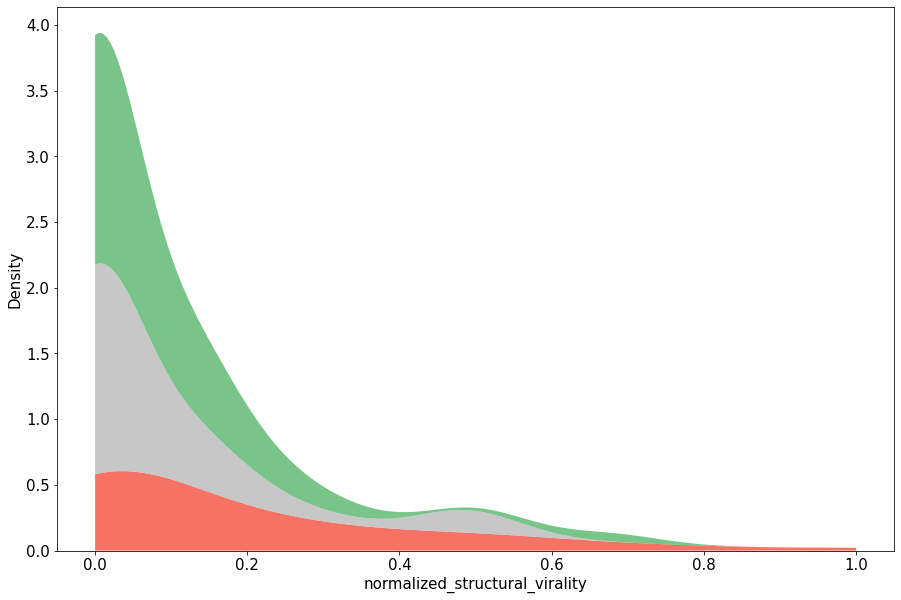

In [ ]:
# @title Smoothed structural virality distrubution

palette = dict(zip([1, 0, -1], list(map(mpl.colors.rgb2hex, sns.color_palette('Greens', 4).as_hex()))[2:3] +
                   list(map(mpl.colors.rgb2hex, sns.color_palette('Greys', 4).as_hex()))[1:2] +
                   list(map(mpl.colors.rgb2hex, sns.color_palette('Reds', 4).as_hex()))[2:3]))

rc = {'figure.figsize': (15, 10),
      'axes.facecolor': 'white',
      'font.size': 15}
plt.rcParams.update(rc)

sns.despine(fig=None, ax=None, top=False, right=False,
            left=False, bottom=False, offset=None, trim=False)
sns.kdeplot(data=a, x='normalized_structural_virality', clip=[
            0, 1], hue='VADER_sentiment_class', multiple='stack', palette=palette, hue_order=palette.keys(), edgecolor=None, legend=None)

In [ ]:
# @title Latent Dirichlet Allocation
text_data = all_tweets_df.sample(100000, random_state=117)[
    'ProcessedContent'].apply(lambda x: nltk.word_tokenize(str(x)))

id2word = corpora.Dictionary(text_data.values.tolist())
corpus = [id2word.doc2bow(text) for text in text_data]

LDA_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=20)

clear_output()

In [ ]:
# @title Latent Dirichlet Allocation visualization

pyLDAvis.enable_notebook()
LDAvis = pyLDAvis.gensim_models.prepare(LDA_model, corpus, id2word)
pyLDAvis.save_html(LDAvis, '---------')
LDAvis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
5     -0.222540  0.121645       1        1  9.451411
18    -0.146485 -0.229719       2        1  8.037937
13    -0.208086  0.077090       3        1  6.574759
10     0.174324  0.081540       4        1  6.097258
16    -0.040554 -0.156498       5        1  5.876973
19     0.183713  0.055990       6        1  5.704228
14    -0.167279  0.091643       7        1  5.611660
12    -0.193936  0.097032       8        1  5.148666
15     0.054996  0.137309       9        1  4.978257
2      0.182087 -0.068393      10        1  4.816329
7     -0.048305 -0.278817      11        1  4.653693
3      0.090702  0.022877      12        1  4.583384
1      0.021353  0.154521      13        1  4.130661
4      0.009539  0.099871      14        1  3.983865
17     0.154109  0.117759      15        1  3.819573
11     0.115650 -0.123070      16        1  3.750159
8      0.073810 -0.059514      17        1  3.570545
6      0.025535 -0.076047      18        1  3.372349
0     -0.097353 -0.020683      19        1  3.076807
9      0.038719 -0.044537      20        1  2.761483, topic_info=          Term          Freq         Total Category  logprob  loglift
2         vape  53916.000000  53916.000000  Default  30.0000  30.0000
35      vaping  31902.000000  31902.000000  Default  29.0000  29.0000
88   cigarette   5005.000000   5005.000000  Default  28.0000  28.0000
68           e   5884.000000   5884.000000  Default  27.0000  27.0000
192       juul  10115.000000  10115.000000  Default  26.0000  26.0000
..         ...           ...           ...      ...      ...      ...
35      vaping    406.592055  31902.865803  Topic20  -4.2768  -0.7732
637   nicotine    140.016629   2390.265773  Topic20  -5.3428   0.7520
61          mg    122.097859    744.920947  Topic20  -5.4798   1.7809
192       juul    129.707889  10115.901721  Topic20  -5.4193  -0.7672
22        time    116.492045   2818.871130  Topic20  -5.5268   0.4031

[1421 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
5413      5  0.983735      abuse
1964      4  0.003236  accessory
1964      5  0.197426  accessory
1964      9  0.796175  accessory
1773      5  0.024103     action
...     ...       ...        ...
2446     17  0.010146    youtube
2446     18  0.010146    youtube
2446     20  0.443025    youtube
224       5  0.997409       zone
753      17  0.973352       zoom

[4547 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 19, 14, 11, 17, 20, 15, 13, 16, 3, 8, 4, 2, 5, 18, 12, 9, 7, 1, 10])

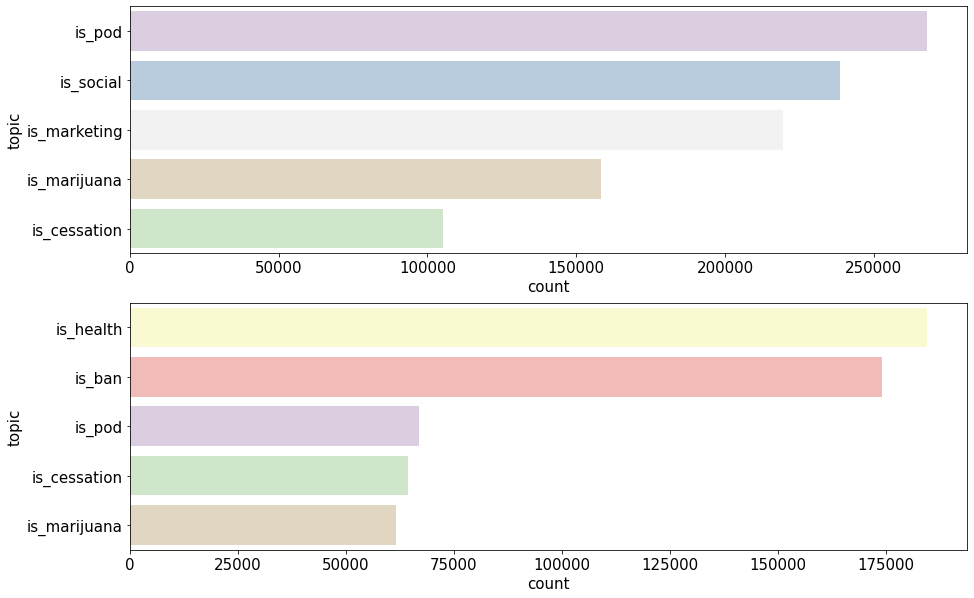

In [ ]:
# @title Top topics per LDA stratified by sentiment class

plt.rcParams["figure.figsize"] = (15, 10)
fig, axs = plt.subplots(nrows=2)
palette = dict(zip(list(interest_tweets_topics.drop('TweetID', axis='columns').columns), list(
    map(mpl.colors.rgb2hex, sns.color_palette('Pastel1', 11).as_hex()))))
sns.countplot(data=pd.merge(all_tweets_df[all_tweets_df['VADER_sentiment_class'] == 1][['TweetID']], interest_tweets_topics, on='TweetID'), y='topic', orient='h', ax=axs[0], order=pd.merge(
    all_tweets_df[all_tweets_df['VADER_sentiment_class'] == 1][['TweetID']], interest_tweets_topics, on='TweetID')['topic'].value_counts().iloc[:5].index, palette=palette)
sns.countplot(data=pd.merge(all_tweets_df[all_tweets_df['VADER_sentiment_class'] == -1][['TweetID']], interest_tweets_topics, on='TweetID'), y='topic', orient='h', ax=axs[1], order=pd.merge(
    all_tweets_df[all_tweets_df['VADER_sentiment_class'] == -1][['TweetID']], interest_tweets_topics, on='TweetID')['topic'].value_counts().iloc[:5].index, palette=palette)

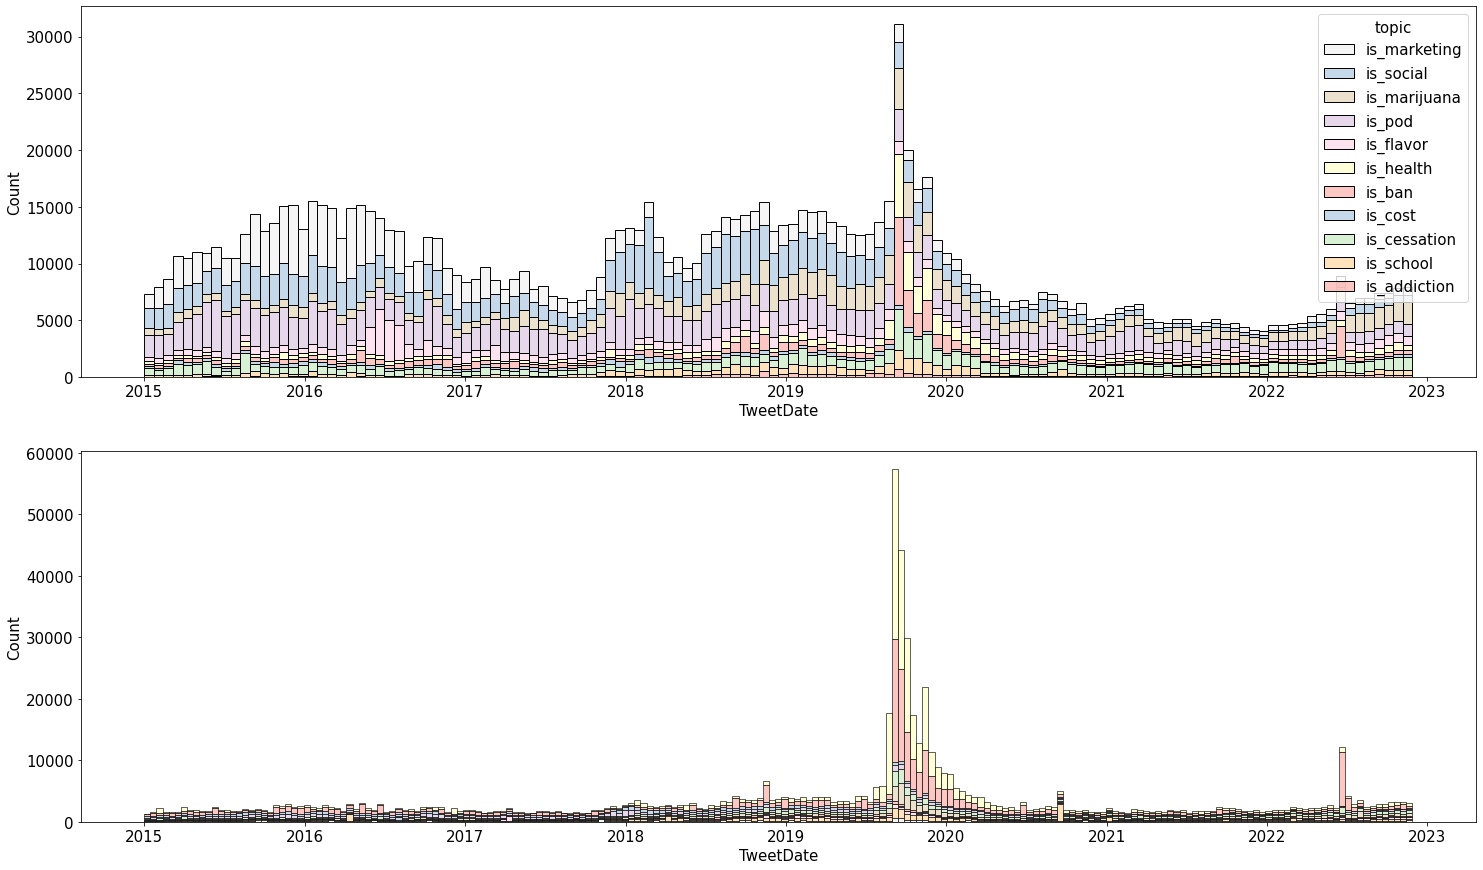

In [ ]:
# @title Top topics per LDA over time stratified by sentiment class

plt.rcParams["figure.figsize"] = (25, 15)
fig, axs = plt.subplots(nrows=2)
palette = dict(zip(list(interest_tweets_topics.drop('TweetID', axis='columns').columns), list(
    map(mpl.colors.rgb2hex, sns.color_palette('Pastel1', 11).as_hex()))))

sns.histplot(data=pd.merge(all_tweets_df[all_tweets_df['VADER_sentiment_class'] == 1][['TweetID', 'TweetDate']],
             interest_tweets_topics, on='TweetID'), x='TweetDate', hue='topic', multiple='stack', ax=axs[0], palette=palette)
sns.histplot(data=pd.merge(all_tweets_df[all_tweets_df['VADER_sentiment_class'] == -1][['TweetID', 'TweetDate']],
             interest_tweets_topics, on='TweetID'), x='TweetDate', hue='topic', multiple='stack', ax=axs[1], legend=False, palette=palette)

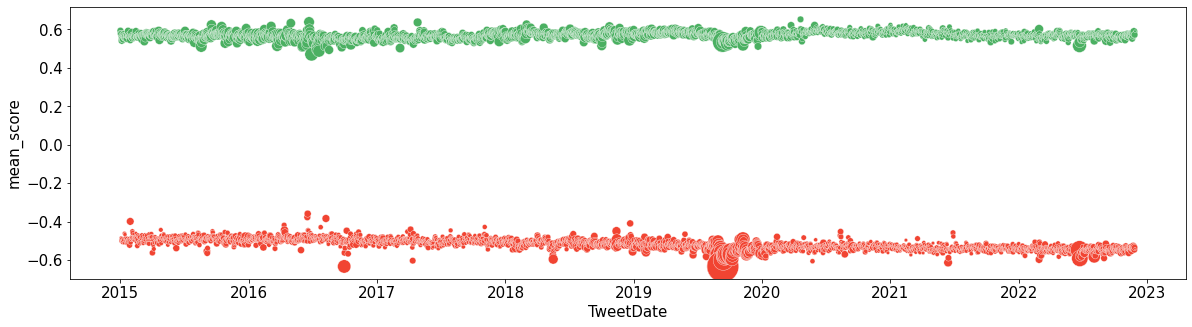

In [ ]:
# @title Mean sentiment over time stratified by sentiment class

palette = dict(zip([1, 0, -1], list(map(mpl.colors.rgb2hex, sns.color_palette('Greens', 4).as_hex()))[2:3] +
                   list(map(mpl.colors.rgb2hex, sns.color_palette('Greys', 4).as_hex()))[1:2] +
                   list(map(mpl.colors.rgb2hex, sns.color_palette('Reds', 4).as_hex()))[2:3]))

rc = {'figure.figsize': (20, 5),
      'axes.facecolor': 'white',
      'font.size': 15}
plt.rcParams.update(rc)

working_tweets = pd.merge(all_tweets_df.groupby(['TweetDate', 'VADER_sentiment_class'])['VADER_sentiment_score'].mean(), all_tweets_df.groupby(['TweetDate', 'VADER_sentiment_class'])[
                          'VADER_sentiment_score'].count(), on=['TweetDate', 'VADER_sentiment_class']).rename({'VADER_sentiment_score_x': 'mean_score', 'VADER_sentiment_score_y': 'sample_size'}, axis='columns')
sns.scatterplot(data=working_tweets[working_tweets.index.get_level_values(1) != 0], x='TweetDate', y='mean_score',
                hue='VADER_sentiment_class', size='sample_size', sizes=(5, 1000), palette=palette, legend=None)
# plt.legend(title='Sentiment',loc='upper left',labels=['Negative','Neutral','Positive'])
sns.despine(fig=None, ax=None, top=False, right=False,
            left=False, bottom=False, offset=None, trim=False)

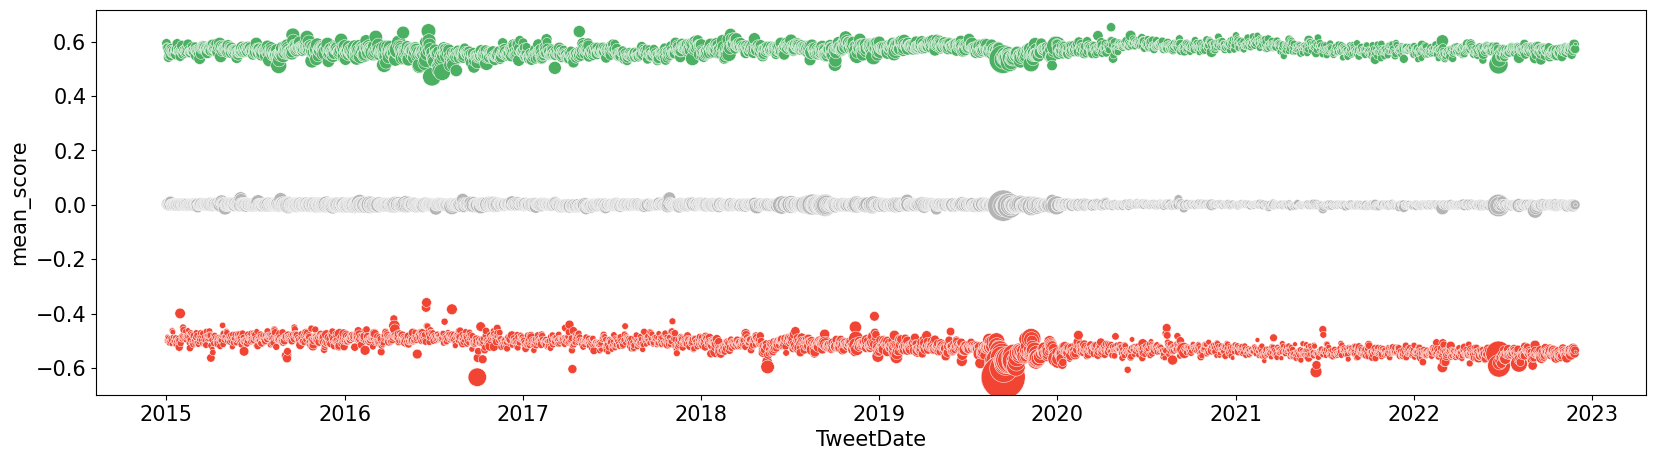

In [ ]:
# @title Mean sentiment over time stratified by sentiment class

palette = dict(zip([1, 0, -1], list(map(mpl.colors.rgb2hex, sns.color_palette('Greens', 4).as_hex()))[2:3] +
                   list(map(mpl.colors.rgb2hex, sns.color_palette('Greys', 4).as_hex()))[1:2] +
                   list(map(mpl.colors.rgb2hex, sns.color_palette('Reds', 4).as_hex()))[2:3]))

rc = {'figure.figsize': (20, 5),
      'axes.facecolor': 'white',
      'font.size': 15}
plt.rcParams.update(rc)

working_tweets = pd.merge(all_tweets_df.groupby(['TweetDate', 'VADER_sentiment_class'])['VADER_sentiment_score'].mean(), all_tweets_df.groupby(['TweetDate', 'VADER_sentiment_class'])[
                          'VADER_sentiment_score'].count(), on=['TweetDate', 'VADER_sentiment_class']).rename({'VADER_sentiment_score_x': 'mean_score', 'VADER_sentiment_score_y': 'sample_size'}, axis='columns')
sns.scatterplot(data=working_tweets, x='TweetDate', y='mean_score', hue='VADER_sentiment_class',
                size='sample_size', sizes=(5, 1000), palette=palette, legend=None)

sns.despine(fig=None, ax=None, top=False, right=False,
            left=False, bottom=False, offset=None, trim=False)

In [ ]:
# Analyze sentiment polarization over time

working_tweets = pd.merge(all_tweets_df.groupby(['TweetDate', 'VADER_sentiment_class'])['VADER_sentiment_score'].mean(), all_tweets_df.groupby(['TweetDate', 'VADER_sentiment_class'])[
                          'VADER_sentiment_score'].count(), on=['TweetDate', 'VADER_sentiment_class']).rename({'VADER_sentiment_score_x': 'mean_score', 'VADER_sentiment_score_y': 'sample_size'}, axis='columns')

working_tweets = working_tweets.reset_index()
working_tweets['TweetDate'] = pd.to_datetime(working_tweets['TweetDate'])
working_tweets['TweetDate'] = working_tweets['TweetDate'].rank(
    method='dense').astype(int)
working_tweets['mean_score'] = pd.to_numeric(
    working_tweets['mean_score'], errors='coerce')

df_class_minus_1 = working_tweets[working_tweets['VADER_sentiment_class'] == -1]

X = sm.add_constant(df_class_minus_1[['TweetDate']])
y = df_class_minus_1['mean_score']

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             mean_score   R-squared:                       0.539
Model:                            OLS   Adj. R-squared:                  0.539
Method:                 Least Squares   F-statistic:                     3371.
Date:                Fri, 17 Nov 2023   Prob (F-statistic):               0.00
Time:                        00:52:30   Log-Likelihood:                 7468.4
No. Observations:                2889   AIC:                        -1.493e+04
Df Residuals:                    2887   BIC:                        -1.492e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4840      0.001   -712.691      0.0

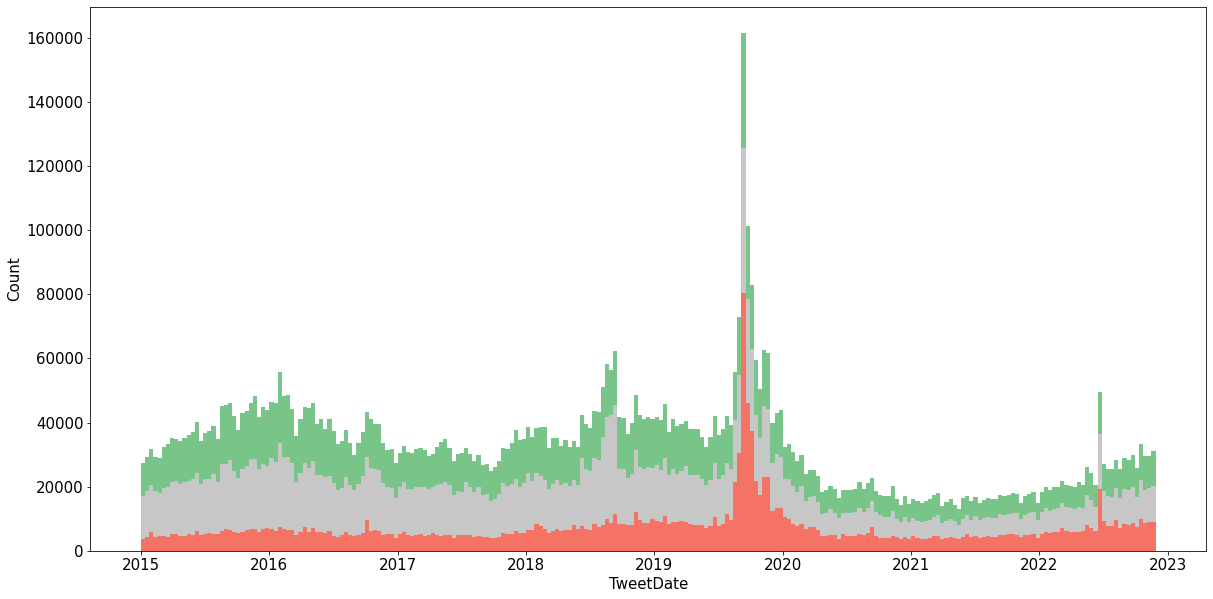

In [ ]:
# @title Tweets over time stratified by sentiment class

palette = dict(zip([1, 0, -1], list(map(mpl.colors.rgb2hex, sns.color_palette('Greens', 4).as_hex()))[2:3] +
                   list(map(mpl.colors.rgb2hex, sns.color_palette('Greys', 4).as_hex()))[1:2] +
                   list(map(mpl.colors.rgb2hex, sns.color_palette('Reds', 4).as_hex()))[2:3]))

rc = {'figure.figsize': (20, 10),
      'axes.facecolor': 'white',
      'font.size': 15}
plt.rcParams.update(rc)

sns.histplot(data=all_tweets_df, x='TweetDate', hue='VADER_sentiment_class',
             multiple='stack', palette=palette, hue_order=palette.keys(), edgecolor=None, legend=None)

sns.despine(fig=None, ax=None, top=False, right=False,
            left=False, bottom=False, offset=None, trim=False)

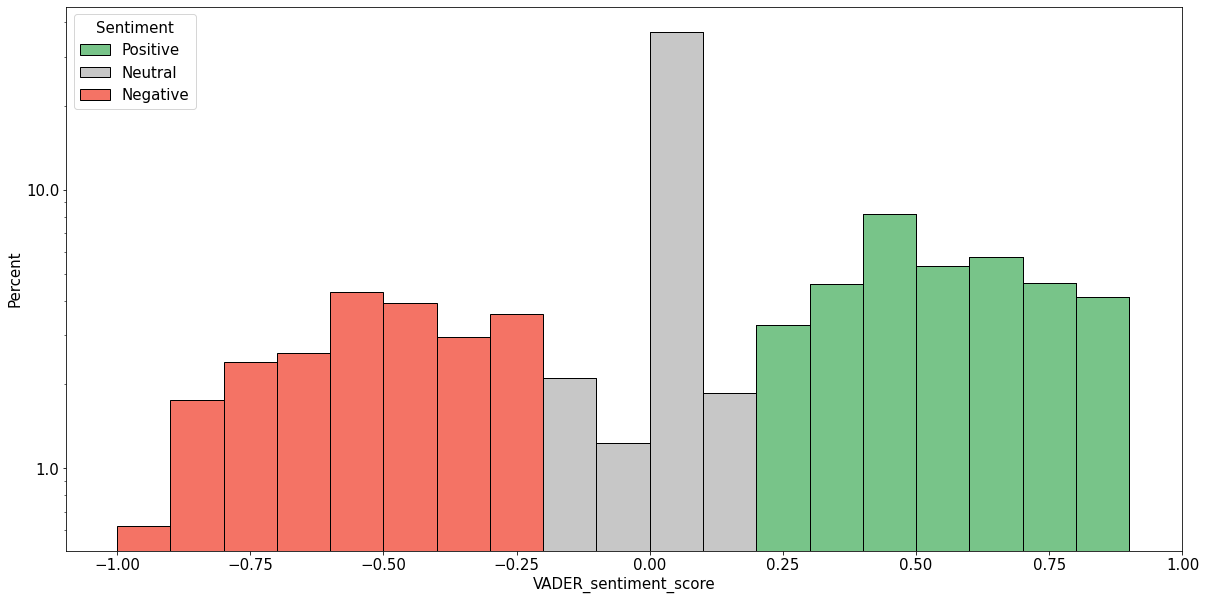

In [ ]:
# @title Tweet sentiment distribution stratified by sentiment class
import matplotlib.ticker as mticker
palette = dict(zip([1, 0, -1], list(map(mpl.colors.rgb2hex, sns.color_palette('Greens', 4).as_hex()))[2:3] +
                   list(map(mpl.colors.rgb2hex, sns.color_palette('Greys', 4).as_hex()))[1:2] +
                   list(map(mpl.colors.rgb2hex, sns.color_palette('Reds', 4).as_hex()))[2:3]))

rc = {'figure.figsize': (20, 10),
      'axes.facecolor': 'white',
      'font.size': 15}
plt.rcParams.update(rc)

ax = sns.histplot(x=all_tweets_df['VADER_sentiment_score'], hue=all_tweets_df['VADER_sentiment_class'],
                  palette=palette, stat='percent', bins=[x/10 for x in range(-10, 10)], multiple='stack')
ax.set_yscale('log')

ax.yaxis.set_major_formatter(mticker.ScalarFormatter())

plt.xticks([-1, -.75, -.5, -.25, 0, .25, .5, .75, 1])
plt.legend(title='Sentiment', loc='upper left',
           labels=['Positive', 'Neutral', 'Negative'])

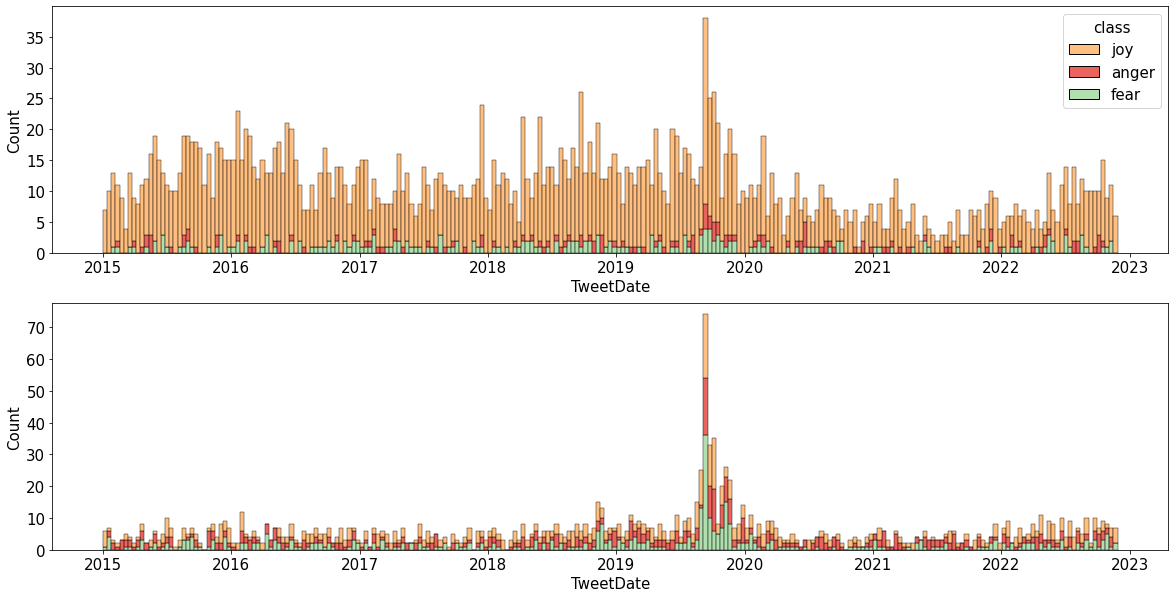

In [ ]:
# @title Tweets over time stratified by emotion class
bins = np.histogram_bin_edges(mdates.date2num(
    all_tweets_df['TweetDate']), bins='auto')
plt.rcParams["figure.figsize"] = (20, 10)
fig, axs = plt.subplots(nrows=2)
gte = interest_tweets_emotions[interest_tweets_emotions['class'].isin(
    ['joy', 'anger', 'fear', 'sadness'])]
palette = dict(zip(
    ['joy']+['anger']+['fear'],
    list(map(mpl.colors.rgb2hex, sns.color_palette('spring', 2).as_hex()))[1:2]+list(map(mpl.colors.rgb2hex, sns.color_palette(
        'Reds', 2).as_hex()))[1:2]+list(map(mpl.colors.rgb2hex, sns.color_palette('Greens', 4).as_hex()))[1:2]
))

sns.histplot(data=pd.merge(all_tweets_df[all_tweets_df['VADER_sentiment_class'] == 1][['TweetID', 'TweetDate']], gte, on='TweetID'),
             x='TweetDate', hue='class', multiple='stack', ax=axs[0], palette=palette, hue_order=palette.keys(), bins=bins)
sns.histplot(data=pd.merge(all_tweets_df[all_tweets_df['VADER_sentiment_class'] == -1][['TweetID', 'TweetDate']], gte, on='TweetID'),
             x='TweetDate', hue='class', multiple='stack', ax=axs[1], palette=palette, hue_order=palette.keys(), legend=False, bins=bins)